# 🌍 IMAGE CLASSIFICATION - Workshop 3

**Student:** Paula Cardona  
**Objective:** This notebook aims to develop a supervised land cover classification workflow using **Sentinel-2 imagery** and **machine learning models**. The process begins by generating monthly median composites from Sentinel-2 Surface Reflectance imagery for the year 2018 over a study area near Ibagué, Colombia. These composite images will serve as input for training and comparing two classification models: **Random Forest** and **SVM**. The results will be evaluated and compared to determine which algorithm performs best under the given conditions.


## 1. Sentinel-2 images search and download

In [3]:
import ee

# Authentication (just once)
ee.Authenticate()

Enter verification code:  4/1AUJR-x5jXbjZuCsj3hSuDyrfHcS59MBeIxUY0VU6B8ZJdz2oeKnjAclrLLA



Successfully saved authorization token.


In [4]:
# Initialization (every time GEE is needed)
ee.Initialize()

print("✅ Successfully Initialized")

✅ Successfully Initialized


In [14]:
import ee
import warnings

# 1. Load AOI
aoi = ee.FeatureCollection("projects/cover-map-project/assets/aoi_wgs84")

# 2. Load the harmonized Sentinel-2 SR collection (recommended)
s2_sr = (ee.ImageCollection("COPERNICUS/S2_SR_HARMONIZED")
         .filterBounds(aoi)
         .filterDate("2018-01-01", "2018-12-31")
         .filter(ee.Filter.lt("CLOUDY_PIXEL_PERCENTAGE", 20)))

# 3. Print image IDs and acquisition dates
ids = s2_sr.aggregate_array("system:index")
dates = s2_sr.aggregate_array("system:time_start").map(lambda t: ee.Date(t).format("YYYY-MM-dd"))

print("🛰️ Image IDs used:")
print(ids.getInfo())

print("\n📅 Acquisition dates:")
print(dates.getInfo())

🛰️ Image IDs used:
['20181227T151659_20181227T151707_T18NWH', '20181230T152639_20181230T152636_T18NVG', '20181230T152639_20181230T152636_T18NWG', '20181230T152639_20181230T152636_T18NWH', '20181230T152639_20181230T152636_T18NXG', '20181230T152639_20181230T152636_T18NXH']

📅 Acquisition dates:
['2018-12-27', '2018-12-30', '2018-12-30', '2018-12-30', '2018-12-30', '2018-12-30']


In [17]:
import datetime
import time

# Select only the relevant bands
selected_bands = ['B2', 'B3', 'B4', 'B8', 'B11', 'B12']
median_2018_selected = s2_sr.select(selected_bands).median().clip(aoi)

# Export image to Google Drive
task = ee.batch.Export.image.toDrive(
    image=median_2018_selected,
    description='Median_2018_SR_selected',
    folder='GEE_exports',  # it is needed to make sure that this folder exists in the personal drive
    fileNamePrefix='median_2018_sr_selected',
    region=aoi.geometry(),
    scale=10,  # Lowest common resolution (10m)
    crs='EPSG:4326',
    maxPixels=1e13
)

task.start()
print("✅ Export task started at:", datetime.datetime.now().strftime("%H:%M:%S"))

# Monitor task status
while task.active():
    print("⏳ Export in progress... checking again in 30 seconds.")
    time.sleep(30)

# Print final status
state = task.status()['state']
print(f"\n📦 Task finished with state: {state}")
if state != 'COMPLETED':
    print("❌ The task failed or was cancelled.")
    print("Details:", task.status())
else:
    print("✅ Export completed successfully!")

✅ Export task started at: 22:32:17
⏳ Export in progress... checking again in 30 seconds.
⏳ Export in progress... checking again in 30 seconds.
⏳ Export in progress... checking again in 30 seconds.
⏳ Export in progress... checking again in 30 seconds.
⏳ Export in progress... checking again in 30 seconds.
⏳ Export in progress... checking again in 30 seconds.
⏳ Export in progress... checking again in 30 seconds.
⏳ Export in progress... checking again in 30 seconds.
⏳ Export in progress... checking again in 30 seconds.
⏳ Export in progress... checking again in 30 seconds.
⏳ Export in progress... checking again in 30 seconds.
⏳ Export in progress... checking again in 30 seconds.
⏳ Export in progress... checking again in 30 seconds.
⏳ Export in progress... checking again in 30 seconds.
⏳ Export in progress... checking again in 30 seconds.
⏳ Export in progress... checking again in 30 seconds.
⏳ Export in progress... checking again in 30 seconds.
⏳ Export in progress... checking again in 30 se

## 1.1. Sentinel-2 images visualization

In [3]:
# Bands validation

import rasterio

img_path = r"/notebooks/WORKSHOP_3/images/median_2018_sr_selected-0000000000-0000000000.tif"

with rasterio.open(img_path) as src:
    print("Band count:", src.count)
    print("Band names:", src.descriptions)

Band count: 6
Band names: ('B2', 'B3', 'B4', 'B8', 'B11', 'B12')


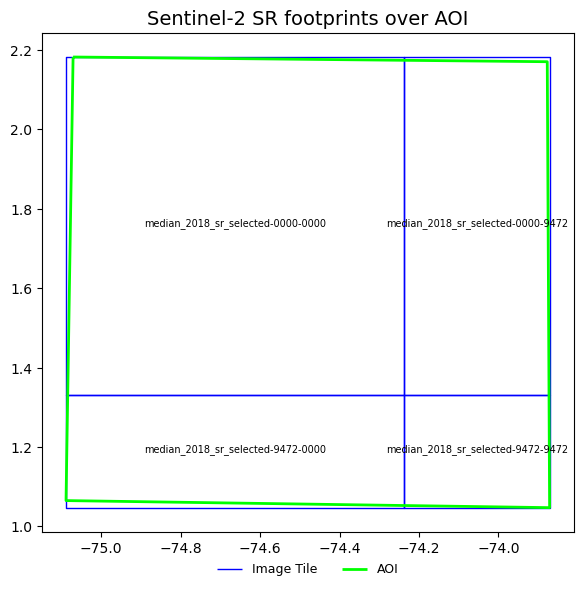

In [38]:
import os
import glob
import geopandas as gpd
from shapely.geometry import box
import matplotlib.pyplot as plt

# Paths
image_dir = r"/notebooks/WORKSHOP_3/images"
aoi_path = r"/notebooks/WORKSHOP_3/AOI/aoi_wgs84.shp"

# AOI
aoi = gpd.read_file(aoi_path)

# image list
image_files = sorted(glob.glob(os.path.join(image_dir, "median_2018_sr_selected-*.tif")))

# footprints generation
footprints = []
names = []

for f in image_files:
    with rasterio.open(f) as src:
        bounds = src.bounds
        footprints.append(box(*bounds))
        # Extract the last two numeric blocks from the file name
        base = os.path.basename(f).replace('.tif', '')
        parts = base.split('-')
        shortname = f"{parts[0]}-{parts[-2][-4:]}-{parts[-1][-4:]}"
        names.append(shortname)

# GeoDataFrame
footprint_gdf = gpd.GeoDataFrame({'filename': names, 'geometry': footprints}, crs="EPSG:4326")

# footprints y AOI plot
fig, ax = plt.subplots(figsize=(6, 6))
footprint_gdf.boundary.plot(ax=ax, edgecolor='blue', linewidth=1, label='Image Tile')
aoi.boundary.plot(ax=ax, edgecolor='lime', linewidth=2, label='AOI')

# Label each image with a simplified name
for idx, row in footprint_gdf.iterrows():
    ax.annotate(
        row["filename"], 
        xy=(row.geometry.centroid.x, row.geometry.centroid.y),  # <- aquí estaba el problema
        fontsize=7, ha='center'
    )

plt.axis('equal') 

# Title
plt.title("Sentinel-2 SR footprints over AOI", fontsize=14)

# Horizontal legend below the chart
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.04), ncol=2, frameon=False, fontsize=9)

# styling
plt.axis('equal')
plt.tight_layout()
plt.show()

### 🧩 Merging Sentinel-2 Tiles from GEE Export

The 2018 median image was exported from Google Earth Engine (GEE) in four separate `.tif` tiles. These tiles represent different parts of the Area of Interest (AOI) and together form a single composite image.

Since they were exported already clipped to the AOI, it wasn't neede to crop them again. However, they were "merged" into one large file to be used for classification.

We used the `gdal_merge.py` tool in the terminal to combine them. To make the output more efficient, we used these options:
- `-of GTiff`: output format is GeoTIFF
- `-co COMPRESS=LZW`: apply compression
- `-co BIGTIFF=YES`: allow output larger than 4GB
- `-co TILED=YES`: optimize for reading in blocks
- `-a_nodata 0`: set no-data value to 0
- `-ot UInt16`: use 16-bit integer (Surface Reflectance values are integers)

### Terminal command:

```bash
gdal_merge.py -o median_2018_sr_merged.tif \
-of GTiff \
-co COMPRESS=LZW \
-co BIGTIFF=YES \
-co TILED=YES \
-a_nodata 0 \
-ot UInt16 \
median_2018_sr_selected-*.tif

### 💡 Additional note
Although the merging process could also be done in Python using `rasterio.merge`, I chose to do it via terminal with `gdal_merge.py` due to its efficiency, precise control over compression and `nodata` settings, and better handling of large files.

The resulting image `median_2018_sr_merged.tif` will be used as the main input for supervised classification models, as it consolidates all the spectral information from the AOI into a single, continuous, and consistent structure.

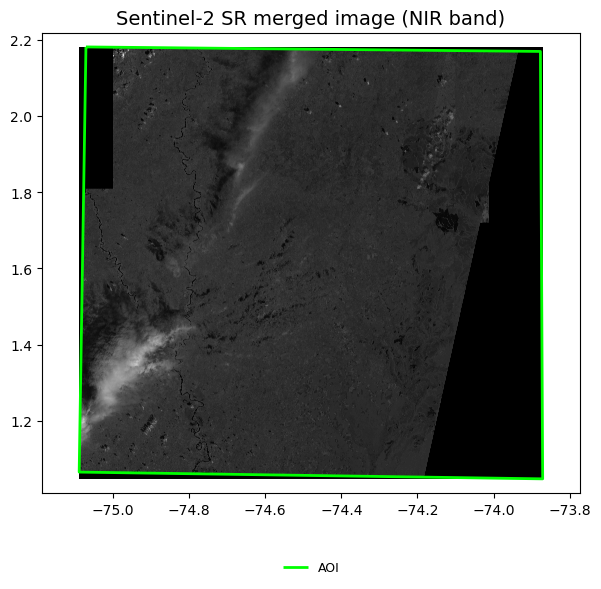

In [1]:
# Final image visaulization

import rasterio
import matplotlib.pyplot as plt
import geopandas as gpd

# Paths
img_path = r"/notebooks/WORKSHOP_3/images/median_2018_sr_merged.tif"
aoi_path = r"/notebooks/WORKSHOP_3/AOI/aoi_wgs84.shp"

# Load AOI
aoi = gpd.read_file(aoi_path)

# Load Band 4 (NIR)
with rasterio.open(img_path) as src:
    red_band = src.read(4) / 10000  # Normalized reflectance
    extent = [src.bounds.left, src.bounds.right, src.bounds.bottom, src.bounds.top]

# Plot
fig, ax = plt.subplots(figsize=(6, 6))
img = ax.imshow(red_band, cmap='gray', extent=extent)
aoi.boundary.plot(ax=ax, edgecolor='lime', linewidth=2, label='AOI')

# Styling
ax.set_title("Sentinel-2 SR merged image (NIR band)", fontsize=14)
ax.legend(loc='lower center', bbox_to_anchor=(0.5, -0.2), ncol=2, fontsize=9, frameon=False)
plt.axis('equal')
plt.tight_layout()
plt.show()

## 2. Import modules for models training

In [1]:
# Base
import os
import random

# Visualization
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

# Spatial analysis
import geopandas as gpd
import rasterio
from shapely.geometry import mapping

import rsgislib
import rsgislib.classification
import rsgislib.classification.classsklearn
import rsgislib.tools.filetools
import rsgislib.tools.mapping
import rsgislib.tools.plotting
import rsgislib.vectorutils
import rsgislib.zonalstats
from sklearn.ensemble import RandomForestClassifier

# Machine learning
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score

print("✅ Modules imported successfully")

✅ Modules imported successfully


In [2]:
# Mask generation

import rasterio
import numpy as np

# Input image path
src_path = r"/notebooks/WORKSHOP_3/images/median_2018_sr_merged.tif"

# Output mask path
mask_path = r"/notebooks/WORKSHOP_3/images/median_2018_sr_mask.tif"

# Abrir imagen y crear máscara binaria donde haya datos válidos
with rasterio.open(src_path) as src:
    img = src.read()  # (bands, height, width)
    profile = src.profile
    profile.update(dtype=rasterio.uint8, count=1)

    # Crear máscara: 1 donde al menos un valor de banda sea > 0
    mask = np.any(img != 0, axis=0).astype(np.uint8)

# Guardar máscara
with rasterio.open(mask_path, "w", **profile) as dst:
    dst.write(mask, 1)

print("✅ Mask created successfully.")

✅ Mask created successfully.


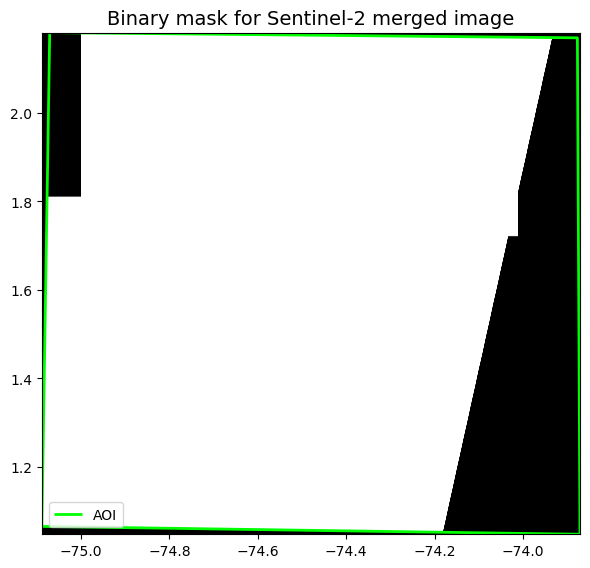

In [3]:
# Mask visualization

import matplotlib.pyplot as plt
import geopandas as gpd
import rasterio

# Paths
mask_path = r"/notebooks/WORKSHOP_3/images/median_2018_sr_mask.tif"
aoi_path = r"/notebooks/WORKSHOP_3/AOI/aoi_wgs84.shp"

# Load AOI
aoi = gpd.read_file(aoi_path)

# Load mask
with rasterio.open(mask_path) as src:
    mask = src.read(1)
    extent = [src.bounds.left, src.bounds.right, src.bounds.bottom, src.bounds.top]

# Plot
fig, ax = plt.subplots(figsize=(6, 6))
ax.imshow(mask, cmap="gray", extent=extent)
aoi.boundary.plot(ax=ax, edgecolor="lime", linewidth=2, label="AOI")
ax.set_title("Binary mask for Sentinel-2 merged image", fontsize=14)
ax.legend(loc="lower left")
ax.axis("on")
plt.tight_layout()
plt.show()

## 3. Allocate input data into variables

Declare the **core inputs** for the classification exercise:

| Variable | File | Purpose |
|----------|------|---------|
| `input_img` | `median_2018_sr_merged.tif` | Multispectral Sentinel-2 image (20 m resolution) to be classified. The image is surface-reflectance corrected and clipped to the AOI. |
| `in_msk_img` | `median_2018_sr_mask.tif  ` | Binary mask for the same image. It flags valid pixels (1) and invalid pixels (0) to be ignored. Required for consistent preprocessing. |
| `vec_train_file` | `datos_ent_val.gpkg ` | Vector file with **training polygons** and **testing points**, both labeled with land cover classes. These will be used to train and validate the classifier. |

In [4]:
# Allocate input paths to variables

input_img = "images/median_2018_sr_merged.tif"       # Merged Sentinel-2 SR image (2018)
in_msk_img = "images/median_2018_sr_mask.tif"        # Binary mask indicating valid pixels
vec_train_file = "datos_ent_val.gpkg"                # GPKG with training polygons and testing points

print("✅ Input paths set successfully.")

✅ Input paths set successfully.


## 4. Explore the data

Get the list of layers within the vector file.

In [5]:
from rsgislib import vectorutils

gpkg_path = r"/notebooks/WORKSHOP_3/datos_ent_val.gpkg"
lyr_names = vectorutils.get_vec_lyrs_lst(gpkg_path)
print("Layers in GPKG:", lyr_names)

Layers in GPKG: ['testing', 'training']


In [6]:
import geopandas as gpd

# Load each layer from the GeoPackage
gdf_train = gpd.read_file(gpkg_path, layer='training')
gdf_test = gpd.read_file(gpkg_path, layer='testing')

# Show unique classes in each layer
print("✅ Classes in training layer:", gdf_train["Name"].unique())
print("✅ Classes in testing layer:", gdf_test["Name"].unique())

# Count class samples in each layer
print("📊 Training class counts:\n", gdf_train["Name"].value_counts())
print("\n📊 Testing class counts:\n", gdf_test["Name"].value_counts())

✅ Classes in training layer: ['artificial_surfaces' 'agricultural_areas' 'forest'
 'shurb_and_herbaceous' 'water_bodies' 'secondary_vegetation'
 'sparsely_or_no_vegetated_areas']
✅ Classes in testing layer: ['agricultural_areas' 'forest' 'shrub_or_herbaceous_vegetation'
 'sparsely_or_no_vegetated_areas' 'secondary_vegetation' 'clouds']
📊 Training class counts:
 Name
shurb_and_herbaceous              56
agricultural_areas                50
secondary_vegetation              32
water_bodies                       9
artificial_surfaces                7
forest                             5
sparsely_or_no_vegetated_areas     4
Name: count, dtype: int64

📊 Testing class counts:
 Name
forest                            44
sparsely_or_no_vegetated_areas    16
clouds                             9
agricultural_areas                 3
shrub_or_herbaceous_vegetation     3
secondary_vegetation               3
Name: count, dtype: int64


### ⚠️ **Note on training and testing data consistency**
>
> During the review of the training (polygon) and testing (point) layers, it was found that:
> - Two classes present in the training layer were missing from the testing layer: `artificial_surfaces` and `water_bodies`.
> - One class present in the testing layer was missing from the training layer: `clouds`.
>
> To ensure a consistent set of land cover classes across both datasets, these missing records were added manually to the `datos_ent_val.gpkg` file using QGIS.
>
> This step is essential to avoid errors during model training and evaluation, and to ensure proper computation of accuracy metrics.

In [7]:
from rsgislib import vectorutils

gpkg_path = r"/notebooks/WORKSHOP_3/datos_ent_val_2.gpkg"
lyr_names = vectorutils.get_vec_lyrs_lst(gpkg_path)
print("Layers in GPKG:", lyr_names)

Layers in GPKG: ['testing', 'training', 'agricultural_areas', 'forest', 'shurb_and_herbaceous', 'artificial_surfaces', 'water_bodies', 'secondary_vegetation', 'sparsely_or_no_vegetated_areas', 'clouds']


In [8]:
import geopandas as gpd

# Load each layer from the GeoPackage
gdf_train = gpd.read_file(gpkg_path, layer='training')
gdf_test = gpd.read_file(gpkg_path, layer='testing')

# Show unique classes in each layer
print("✅ Classes in training layer:", gdf_train["Name"].unique())
print("✅ Classes in testing layer:", gdf_test["Name"].unique())

# Count class samples in each layer
print("📊 Training class counts:\n", gdf_train["Name"].value_counts())
print("\n📊 Testing class counts:\n", gdf_test["Name"].value_counts())

✅ Classes in training layer: ['clouds' 'artificial_surfaces' 'agricultural_areas' 'forest'
 'shurb_and_herbaceous' 'water_bodies' 'secondary_vegetation'
 'sparsely_or_no_vegetated_areas']
✅ Classes in testing layer: ['artificial_surfaces' 'clouds' 'forest' 'shurb_and_herbaceous'
 'sparsely_or_no_vegetated_areas' 'secondary_vegetation' 'water_bodies']
📊 Training class counts:
 Name
shurb_and_herbaceous              54
agricultural_areas                47
secondary_vegetation              32
clouds                            12
water_bodies                      10
forest                             5
artificial_surfaces                4
sparsely_or_no_vegetated_areas     4
Name: count, dtype: int64

📊 Testing class counts:
 Name
forest                            40
sparsely_or_no_vegetated_areas    16
clouds                            14
water_bodies                      12
artificial_surfaces                5
shurb_and_herbaceous               3
secondary_vegetation               3
Name

Sub-image bounding box: [-74.63205181   1.47283681 -74.32766034   1.75649115]


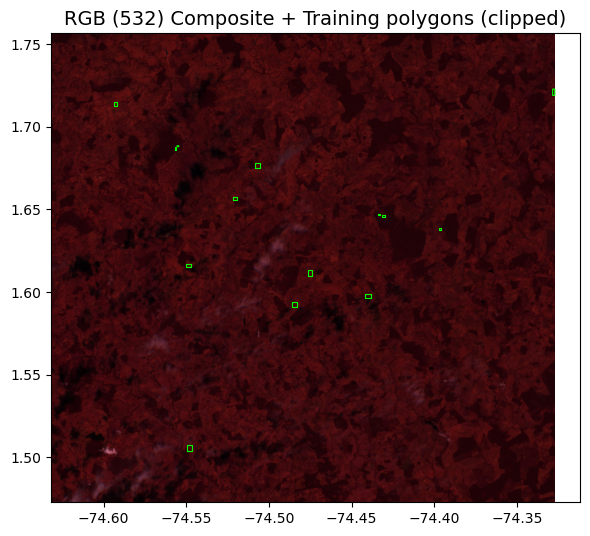

In [9]:
import geopandas as gpd
import rasterio
import numpy as np
import matplotlib.pyplot as plt
from shapely.geometry import box

# -------------------------------
# 1. AOI oand reduced bbox (25%)
aoi = gpd.read_file(r"/notebooks/WORKSHOP_3/AOI/aoi_wgs84.shp")
minx, miny, maxx, maxy = aoi.total_bounds

reduction_factor = 0.25
width = maxx - minx
height = maxy - miny
new_width = width * reduction_factor
new_height = height * reduction_factor
new_minx = minx + (width - new_width) / 2
new_maxx = new_minx + new_width
new_miny = miny + (height - new_height) / 2
new_maxy = new_miny + new_height

bbox_geom = box(new_minx, new_miny, new_maxx, new_maxy)
bbox_gdf = gpd.GeoDataFrame(geometry=[bbox_geom], crs=aoi.crs)
print("Sub-image bounding box:", bbox_gdf.total_bounds)

# -------------------------------
# 2. Load image and crop display to a reduced bounding box, to avoid kernel restart
img_path = r"/notebooks/WORKSHOP_3/images/median_2018_sr_merged.tif"
with rasterio.open(img_path) as src:
    window = src.window(new_minx, new_miny, new_maxx, new_maxy)
    red = src.read(5, window=window)
    green = src.read(3, window=window)
    blue = src.read(2, window=window)
    transform = src.window_transform(window)

# -------------------------------
# 3. Normalize bands and create RGB image
def normalize(band):
    return (band - band.min()) / (band.max() - band.min())

rgb = np.dstack((normalize(red), normalize(green), normalize(blue)))

# -------------------------------
# 4. Load training layer and crop to reduced bbox
gdf_train = gpd.read_file(r"/notebooks/WORKSHOP_3/datos_ent_val_2.gpkg", layer="training")
gdf_train_clip = gdf_train.cx[new_minx:new_maxx, new_miny:new_maxy]

# -------------------------------
# 5. Plot RGB image with training polygons
fig, ax = plt.subplots(figsize=(6, 6))
extent = [new_minx, new_maxx, new_miny, new_maxy]
ax.imshow(rgb, extent=extent)
gdf_train_clip.boundary.plot(ax=ax, edgecolor='lime', linewidth=0.8)
ax.set_title("RGB (532) Composite + Training polygons (clipped)", fontsize=14)
plt.tight_layout()
plt.show()

## Image and band definition

In [10]:
from rsgislib.imageutils import ImageBandInfo

# image path
input_img = r"/notebooks/WORKSHOP_3/images/median_2018_sr_merged.tif"

# band definition: [R, G, B, NIR, SWIR1, SWIR2] → [3, 2, 1, 4, 5, 6]
img_band_info = []
img_band_info.append(
    ImageBandInfo(
        file_name=input_img,
        name="sentinel_2018",
        bands=[3, 2, 1, 4, 5, 6]
    )
)

print("Bandas definidas:", img_band_info)

Bandas definidas: [('sentinel_2018', [3, 2, 1, 4, 5, 6], '/notebooks/WORKSHOP_3/images/median_2018_sr_merged.tif')]


In [11]:
# class import and list creation

from rsgislib.classification import ClassVecSamplesInfoObj

# List to store info by class
class_vec_sample_info = []

print("✅ List created successfully")
print(class_vec_sample_info)

✅ List created successfully
[]


In [12]:
from rsgislib.classification import ClassVecSamplesInfoObj
import inspect, textwrap, pprint

sig = inspect.signature(ClassVecSamplesInfoObj.__init__)
print("✔️  Signature supported by the installed rsgislib version:")
pprint.pprint(sig)

✔️  Signature supported by the installed rsgislib version:
<Signature (self, id=None, class_name=None, vec_file=None, vec_lyr=None, file_h5=None)>


In [13]:
# Extraction of each layer in a single gpkg

import geopandas as gpd

src_gpkg   = r"/notebooks/WORKSHOP_3/datos_ent_val_2.gpkg"
dst_gpkg   = src_gpkg          
classes    = ["agricultural_areas", "forest", "shurb_and_herbaceous",
              "artificial_surfaces", "water_bodies",
              "secondary_vegetation", "sparsely_or_no_vegetated_areas",
              "clouds"]

gdf_train = gpd.read_file(src_gpkg, layer="training")

for cls in classes:
    gdf_cls = gdf_train[gdf_train["Name"] == cls]
    gdf_cls.to_file(dst_gpkg, layer=cls, driver="GPKG")
    print(f"✔️  layer '{cls}' escrito con {len(gdf_cls)} features")

✔️  layer 'agricultural_areas' escrito con 47 features
✔️  layer 'forest' escrito con 5 features
✔️  layer 'shurb_and_herbaceous' escrito con 54 features
✔️  layer 'artificial_surfaces' escrito con 4 features
✔️  layer 'water_bodies' escrito con 10 features
✔️  layer 'secondary_vegetation' escrito con 32 features
✔️  layer 'sparsely_or_no_vegetated_areas' escrito con 4 features
✔️  layer 'clouds' escrito con 12 features


In [14]:
# --------------------------------------------
# Define 8 classes and their HDF5 files
# --------------------------------------------

from rsgislib.classification import ClassVecSamplesInfoObj
vec_train_file   = r"/notebooks/WORKSHOP_3/datos_ent_val_2.gpkg"
class_vec_sample_info = []

def add_class(id, lyr_name):
    class_vec_sample_info.append(
        ClassVecSamplesInfoObj(
            id=id,
            class_name=lyr_name,       
            vec_file=vec_train_file,
            vec_lyr=lyr_name,           
            file_h5=f"{lyr_name}_smpls.h5"
        )
    )

add_class(1, "agricultural_areas")
add_class(2, "forest")
add_class(3, "shurb_and_herbaceous")      
add_class(4, "artificial_surfaces")
add_class(5, "water_bodies")
add_class(6, "secondary_vegetation")
add_class(7, "sparsely_or_no_vegetated_areas")
add_class(8, "clouds")

print("✅  List reconstructed with independent layers")

✅  List reconstructed with independent layers


In [15]:
# Temporary directory creaction

import os
tmp_dir = r"/notebooks/WORKSHOP_3/tmp_training_data"

if not os.path.exists(tmp_dir):
    os.mkdir(tmp_dir)

print("✅ Temporary directory created successfully")

✅ Temporary directory created successfully


In [18]:
import rsgislib
print("Versión de RSGISLib:", rsgislib.__version__)

import rsgislib.classification.classsklearn as csk
print("\nContenido de rsgislib.classification.classssklearn:")
print("\n".join(dir(csk)))

Versión de RSGISLib: 5.1.7

Contenido de rsgislib.classification.classssklearn:
BaseEstimator
BaseSearchCV
Dict
List
TQDM_AVAIL
Union
__builtins__
__cached__
__doc__
__file__
__loader__
__name__
__package__
__spec__
applier
apply_sklearn_classifier
apply_sklearn_classifier_rat
feat_sel_sklearn_multiclass_borutashap
gdal
h5py
numpy
perform_sklearn_classifier_param_search
rat
ratapplier
rsgislib
tqdm
train_sklearn_classifier


In [19]:
import inspect
from rsgislib.classification import get_class_training_data

print("Firma de get_class_training_data:")
print(inspect.signature(get_class_training_data))

Firma de get_class_training_data:
(img_band_info: List[rsgislib.imageutils.ImageBandInfo], class_vec_sample_info: List[rsgislib.classification.ClassVecSamplesInfoObj], tmp_dir: str, sub_sample: int = None, ref_img: str = None) -> dict


In [20]:
from rsgislib.classification import get_class_training_data

get_class_training_data(
    img_band_info=img_band_info,
    class_vec_sample_info=class_vec_sample_info,
    tmp_dir=tmp_dir
)
print("✔ Extracción terminada – nuevos .h5 escritos en tmp_training_data")

0) /notebooks/WORKSHOP_3/images/median_2018_sr_merged.tif
Creating output image using input image
New image width = 13554 height = 12631 bands = 1


Running Rasterise now...
Get Image Min and Max.

Creating output image using input imageGet Image Histogram.

Adding Histogram and Colour Table to image file
Calculating Image Pyramids.




Running Rasterise now...
Get Image Min and Max.

Creating output image using input image
Running Rasterise now...Get Image Histogram.

Adding Histogram and Colour Table to image file
Calculating Image Pyramids.




Get Image Min and Max.

Get Image Histogram.

Adding Histogram and Colour Table to image file
Calculating Image Pyramids.

Creating output image using input image

Running Rasterise now...

Get Image Min and Max.

Get Image Histogram.

Adding Histogram and Colour Table to image file
Calculating Image Pyramids.


Creating output image using input image

Running Rasterise now...
Get Image Min and Max.

Creating output image using input image
Ru

In [21]:
from rsgislib.classification import get_num_samples

print("\n📊  Sample count per class class_vec_sample_info\n")
for cls in class_vec_sample_info:
    n = get_num_samples(cls.file_h5)
    print(f"{cls.class_name:35}: {n:8d}")


📊  Sample count per class class_vec_sample_info

agricultural_areas                 :    47511
forest                             :    24592
shurb_and_herbaceous               :    78968
artificial_surfaces                :     2206
water_bodies                       :     4510
secondary_vegetation               :     5487
sparsely_or_no_vegetated_areas     :      990
clouds                             :    16883


In [40]:
from rsgislib.classification import get_class_training_data

cls_smpls_info = get_class_training_data(
    img_band_info,          # ImageBandInfo list
    class_vec_sample_info,  # ClassVecSamplesInfoObj list
    tmp_dir=tmp_dir         # temporary folder for .h5 files
)
print("✅ Dictionary cls_smpls_info constructed")

Creating output image using input image0) /notebooks/WORKSHOP_3/images/median_2018_sr_merged.tif

New image width = 13554 height = 12631 bands = 1


Running Rasterise now...
Get Image Min and Max.

Get Image Histogram.

Adding Histogram and Colour Table to image file
Calculating Image Pyramids.

Creating output image using input image
Running Rasterise now...


Get Image Min and Max.

Get Image Histogram.

Adding Histogram and Colour Table to image file
Calculating Image Pyramids.


Creating output image using input image
Running Rasterise now...

Get Image Min and Max.

Get Image Histogram.

Adding Histogram and Colour Table to image file
Calculating Image Pyramids.


Creating output image using input image

Running Rasterise now...
Get Image Min and Max.

Creating output image using input image
Running Rasterise now...
Get Image Histogram.

Adding Histogram and Colour Table to image file
Calculating Image Pyramids.



Get Image Min and Max.

Get Image Histogram.

Adding Histogram and

In [35]:
# checkin classes after recreating dictionary

print("\n🔑  cls_smpls_info:\n")
for k in cls_smpls_info:
    print(" •", k)


🔑  cls_smpls_info:

 • agricultural_areas
 • forest
 • shurb_and_herbaceous
 • artificial_surfaces
 • water_bodies
 • secondary_vegetation
 • sparsely_or_no_vegetated_areas
 • clouds


In [36]:
# Class colours definition

# -------------------------------------
# Dictionary {class_name: ((R, G, B), "Colour‐Name")}
cls_rgb = {
    "agricultural_areas"          : ((142,  28, 211), "Purple"),
    "forest"                      : ((155, 247,  20), "Lime-Green"),
    "shurb_and_herbaceous"        : ((219, 112, 255), "Magenta"),
    "artificial_surfaces"         : ((162, 208,   3), "Olive-Green"),
    "water_bodies"                : ((  0,   0, 255), "Blue"),
    "secondary_vegetation"        : ((249, 216,  62), "Mustard"),
    "sparsely_or_no_vegetated_areas":(( 38,  37, 122), "Indigo"),
    "clouds"                      : ((255, 255, 255), "White"),
}

# --- RGB and name for each object in class_vec_sample_info  list---
for cls in class_vec_sample_info:
    if cls.class_name not in cls_rgb:
        raise ValueError(f"⚠️ Falta color para la clase '{cls.class_name}'")

     (r, g, b), clr_name = cls_rgb[cls.class_name]

    # Saving the object properties
    cls.red   = r
    cls.green = g
    cls.blue  = b
    cls.colour_name = clr_name  # opcional, solo si lo quieres

print("\n✅ Colores asignados a todos los objetos")


✅ Colores asignados a todos los objetos


In [37]:
# Function to extract samples from each class

from rsgislib.classification import get_num_samples

print("\n📊  Sample count per class")
for cls in class_vec_sample_info:
    n = get_num_samples(cls.file_h5)
    print(f"{cls.class_name:35}: {n:8d}")


📊  Sample count per class
agricultural_areas                 :    47511
forest                             :    24592
shurb_and_herbaceous               :    78968
artificial_surfaces                :     2206
water_bodies                       :     4510
secondary_vegetation               :     5487
sparsely_or_no_vegetated_areas     :      990
clouds                             :    16883


In [38]:
# ----------------------------------------------
# Create / reuse a folder where the split files
# will be written
# ----------------------------------------------
import os

smpls_dir = r"/notebooks/WORKSHOP_3/cls_smpls"
os.makedirs(smpls_dir, exist_ok=True)
print("✅  sample-folder:", smpls_dir)

✅  sample-folder: /notebooks/WORKSHOP_3/cls_smpls


In [39]:
# ----------------------------------------------
# Build the new dict with _train / _valid / _test
# ----------------------------------------------
from rsgislib.classification import get_class_info_dict

cls_smpls_info = get_class_info_dict(
    cls_smpls_info,      
    smpls_dir            # HDF5
)

print("✅ keys:\n", list(cls_smpls_info.keys())[:3], "...")

0=1: (Train:/notebooks/WORKSHOP_3/cls_smpls/agricultural_areas_smpls_train.h5, Test:/notebooks/WORKSHOP_3/cls_smpls/agricultural_areas_smpls_test.h5, Valid:/notebooks/WORKSHOP_3/cls_smpls/agricultural_areas_smpls_valid.h5), (74, 224, 242)
1=2: (Train:/notebooks/WORKSHOP_3/cls_smpls/forest_smpls_train.h5, Test:/notebooks/WORKSHOP_3/cls_smpls/forest_smpls_test.h5, Valid:/notebooks/WORKSHOP_3/cls_smpls/forest_smpls_valid.h5), (230, 175, 229)
2=3: (Train:/notebooks/WORKSHOP_3/cls_smpls/shurb_and_herbaceous_smpls_train.h5, Test:/notebooks/WORKSHOP_3/cls_smpls/shurb_and_herbaceous_smpls_test.h5, Valid:/notebooks/WORKSHOP_3/cls_smpls/shurb_and_herbaceous_smpls_valid.h5), (249, 75, 1)
3=4: (Train:/notebooks/WORKSHOP_3/cls_smpls/artificial_surfaces_smpls_train.h5, Test:/notebooks/WORKSHOP_3/cls_smpls/artificial_surfaces_smpls_test.h5, Valid:/notebooks/WORKSHOP_3/cls_smpls/artificial_surfaces_smpls_valid.h5), (124, 133, 187)
4=5: (Train:/notebooks/WORKSHOP_3/cls_smpls/water_bodies_smpls_train.h5

In [49]:
from rsgislib.classification import create_train_valid_test_sets

# Fixed amounts (None for "the rest")
n_test  = 200
n_valid = 200
n_train = None   # Remaining samples

create_train_valid_test_sets(
    cls_in_info  = cls_smpls_info,      # <-- dict ClassSimpleInfoObj 
    cls_out_info = cls_smpls_fnl_info,  # <-- dict generated with get_class_info_dict
    test_sample  = n_test,
    valid_sample = n_valid,
    train_sample = n_train,
    rnd_seed     = 42,
    datatype     = None   
)

print("✅ HDF5 de Train/Valid/Test creados en:", smpls_dir)


✅ HDF5 de Train/Valid/Test creados en: /notebooks/WORKSHOP_3/cls_smpls


### Random Forest Training

In [50]:
# Hyperparameter Optimization

# Grid-search on Random Forest  ✅
from rsgislib.classification.classsklearn import (
    perform_sklearn_classifier_param_search
)
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV


# ← search grid
param_grid = {
    "n_estimators": [ 50, 100, 150, 200],
    "max_depth"   : [ 8, 12, 16],
}

grid_search = GridSearchCV(
    RandomForestClassifier(),
    param_grid,
    n_jobs = -1,      
    cv     = 5,       
)

sk_classifier = perform_sklearn_classifier_param_search(
    cls_smpls_fnl_info,
    grid_search
)

print("\n🎯 Best score :", grid_search.best_score_)
print("🔧 Best params:", grid_search.best_params_)

Training data size: 1700 x 6
Best score was 0.8605882352941177 and has parameters {'max_depth': 12, 'n_estimators': 100}.

🎯 Best score : 0.8605882352941177
🔧 Best params: {'max_depth': 12, 'n_estimators': 100}


In [51]:
from joblib import dump
from pathlib import Path

# 1.1 Folder where the model will be saved
models_dir = Path("/notebooks/WORKSHOP_3/models")
models_dir.mkdir(exist_ok=True)

# 1.2 File name
rf_model_path = models_dir / "rf_best.joblib"

# 1.3 Save the model with joblib.dump
dump(sk_classifier, rf_model_path)
print(f"✅ RF model saved → {rf_model_path}")

✅ RF model saved → /notebooks/WORKSHOP_3/models/rf_best.joblib


In [53]:
# Preparing band information for classification (ImageBandInfo))

from rsgislib.imageutils import ImageBandInfo

# 2.1 Route to the image to be classified
mos_path = "/notebooks/WORKSHOP_3/images/median_2018_sr_merged.tif"

band_names = ['B2','B3','B4','B8','B11','B12']
img_band_info = [
    ImageBandInfo(
        file_name = mos_path,
        name      = "sentinel_2018",
        bands     = [3, 2, 1, 4, 5, 6]
    )
]
print("✅ ImageBandInfo list:", img_band_info)

✅ ImageBandInfo list: [('sentinel_2018', [3, 2, 1, 4, 5, 6], '/notebooks/WORKSHOP_3/images/median_2018_sr_merged.tif')]


In [56]:
from joblib import load
from pathlib import Path
from rsgislib.classification.classsklearn import apply_sklearn_classifier
from rsgislib.imageutils import ImageBandInfo

# ——————————————————————————————
# 1) Load the trained Random Forest model
# ——————————————————————————————
rf_model_path = Path("/notebooks/WORKSHOP_3/models/rf_best.joblib")
sk_classifier = load(str(rf_model_path))


# ——————————————————————————————
# 2) Input/output paths
# ——————————————————————————————
mos_path    = "/notebooks/WORKSHOP_3/images/median_2018_sr_merged.tif"   # tu mosaico Sentinel-2
mask_path   = "/notebooks/WORKSHOP_3/images/median_2018_sr_mask.tif"     # la máscara 0/1 que ya tenías
out_cls_img = "/notebooks/WORKSHOP_3/results/rf_classification.kea"      # salida en KEA


# ——————————————————————————————
# 3) List ImageBandInfo rebuilding

img_band_info = [
    ImageBandInfo(
        file_name = mos_path,
        name      = "sentinel_2018",
        bands     = [3, 2, 1, 4, 5, 6]
    )
]
print(f"✅ ImageBandInfo list:  {img_band_info}")


# ——————————————————————————————
# 4) apply_sklearn_classifier (gdalformat="KEA" instead of "GTiff")
# ——————————————————————————————
apply_sklearn_classifier(
    cls_train_info        = cls_smpls_fnl_info,  # HDF5 (train/valid/test)
    sk_classifier         = sk_classifier,       # RandomForest
    in_msk_img            = str(mask_path),      # TIFF mask (0/1)
    img_msk_val           = 1,                   # only == 1 pixels
    img_file_info         = img_band_info,       # List ImageBandInfo
    out_class_img         = str(out_cls_img),    # output path (.kea)
    gdalformat            = "KEA",               
    class_clr_names       = False,               
    out_score_img         = None,                
    ignore_consec_cls_ids = False                
)

print(f"✅ Classification saved → {out_cls_img}")

✅ ImageBandInfo list:  [('sentinel_2018', [3, 2, 1, 4, 5, 6], '/notebooks/WORKSHOP_3/images/median_2018_sr_merged.tif')]
Applying the Classifier


  0%|          | 0/100 [00:00<?, ?it/s]

/opt/miniconda/lib/python3.11/site-packages/osgeo/gdal.py:3842: RuntimeWarning: Caught exception in KEADataset constructor Could not retrieve image band meta data.
  return _gdal.Driver_Delete(self, *args)


Completed
Get Image Min and Max.

Get Image Histogram.

Adding Histogram and Colour Table to image file
Calculating Image Pyramids.

✅ Classification saved → /notebooks/WORKSHOP_3/results/rf_classification.kea


### Results visualization

In [57]:
# Import libraries and define file paths + clipping window

# Import needed libraries
import numpy as np
import rasterio
from rasterio.windows import Window
import os

# Define file paths for the median image and the classified output
# ------------------------------------------------------------------------
# Path to the median image that will be classified
img_mediana_fp = "/notebooks/WORKSHOP_3/images/median_2018_sr_merged.tif"

# Path to the classified result (KEA) produced by the RF model
cls_predicted_fp = "/notebooks/WORKSHOP_3/results/rf_classification.kea"

# Define the clipping window (row_off, col_off, width, height)
# ------------------------------------------------------------------
# row_off: starting row index (pixel)
# col_off: starting column index (pixel)
# win_width: width of the window (number of pixels)
# win_height: height of the window (number of pixels)

row_off    = 2000   # <— first row of the window (adjust to your area of interest)
col_off    = 3500   # <— first column of the window (adjust to your area of interest)
win_width  = 500    # <— width of the snippet in pixels
win_height = 500    # <— height of the snippet in pixels

# Construct the rasterio Window object
window = Window(col_off, row_off, win_width, win_height)

# Check that both files exist (this helps catch wrong file paths)
# ----------------------------------------------------------------------
print("✅ Checking file existence:")
print("   Median image exists?      ", os.path.exists(img_mediana_fp))
print("   Classified image exists?  ", os.path.exists(cls_predicted_fp))
print("✅ Window defined → Row offset:", row_off, 
      "Col offset:", col_off, "Width:", win_width, "Height:", win_height)

✅ Checking file existence:
   Median image exists?       True
   Classified image exists?   True
✅ Window defined → Row offset: 2000 Col offset: 3500 Width: 500 Height: 500


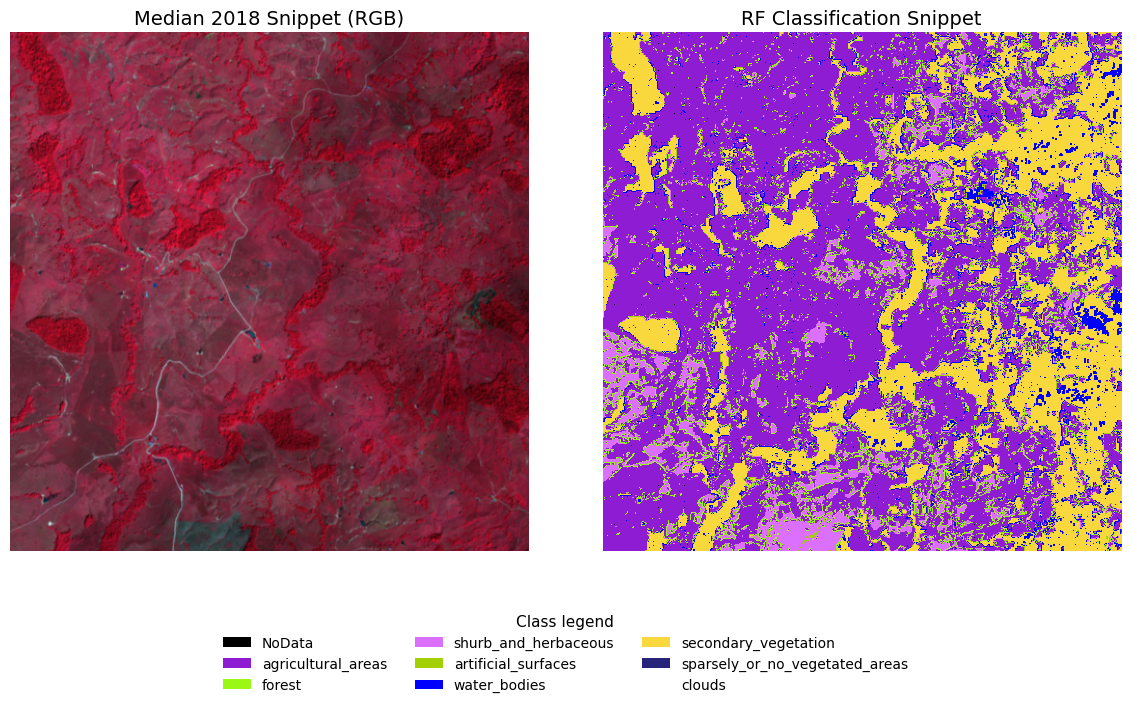

In [59]:
# -------------------------------------------------------------------
# Read clipped window from both rasters and plot side by side,
# -------------------------------------------------------------------

import numpy as np
import rasterio
import matplotlib.pyplot as plt
from rasterio.windows import Window
from matplotlib.colors import ListedColormap, BoundaryNorm
from matplotlib.patches import Patch

# Band normalization
def normalize_band(band):
    """
    Normalize a 2D numpy array to the range [0,1], preserving dtype float.
    """
    minv = band.min()
    maxv = band.max()
    if maxv - minv == 0:
        return np.zeros_like(band, dtype="float32")
    return (band.astype("float32") - float(minv)) / float(maxv - minv)

# 2) Snippet (window) of Sentinel-2 merged
with rasterio.open(img_mediana_fp) as src_med:
    red_snip   = src_med.read(4, window=window)  # R
    green_snip = src_med.read(3, window=window)  # G
    blue_snip  = src_med.read(2, window=window)  # B

rgb_snip = np.dstack([
    normalize_band(red_snip),
    normalize_band(green_snip),
    normalize_band(blue_snip)
])

# 4) Snippet (window) of classification (KEA)
with rasterio.open(cls_predicted_fp) as src_cls:
    cls_snip = src_cls.read(1, window=window)  # Valores de clase (0..8)

# 5) ListedColormap according to cls_rgb
cls_rgb = {
    "agricultural_areas"            : (142,  28, 211),
    "forest"                        : (155, 247,  20),
    "shurb_and_herbaceous"          : (219, 112, 255),
    "artificial_surfaces"           : (162, 208,   3),
    "water_bodies"                  : (  0,   0, 255),
    "secondary_vegetation"          : (249, 216,  62),
    "sparsely_or_no_vegetated_areas": ( 38,  37, 122),
    "clouds"                        : (255, 255, 255)
}

ordered_keys = [
    "agricultural_areas",
    "forest",
    "shurb_and_herbaceous",
    "artificial_surfaces",
    "water_bodies",
    "secondary_vegetation",
    "sparsely_or_no_vegetated_areas",
    "clouds"
]

# List of colours
col_list = [(0.0, 0.0, 0.0)] 

for key in ordered_keys:
    r, g, b = cls_rgb[key]
    col_list.append((r/255.0, g/255.0, b/255.0))

cmap_cls = ListedColormap(col_list)
bounds = np.arange(len(col_list) + 1)  # [0,1,2,...,9]
norm  = BoundaryNorm(bounds, cmap_cls.N)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

# Snippet RGB (left)
ax1.imshow(rgb_snip)
ax1.set_title("Median 2018 Snippet (RGB)", fontsize=14)
ax1.axis("off")

# Snippet classification (right)
im2 = ax2.imshow(cls_snip, cmap=cmap_cls, norm=norm)
ax2.set_title("RF Classification Snippet", fontsize=14)
ax2.axis("off")

# Leyend
legend_items = []
for idx, class_name in enumerate(["NoData"] + ordered_keys):
    color = col_list[idx]
    legend_items.append(Patch(facecolor=color, edgecolor="none", label=class_name))

#    - Subplot_adjust aumenta el espacio inferior (bottom) para la leyenda
#    - BBox_to_anchor coloca la leyenda justo por debajo
fig.tight_layout(rect=[0, 0.08, 1, 1])  

fig.legend(
    handles=legend_items,
    title="Class legend",
    bbox_to_anchor=(0.5, 0.02), 
    loc="upper center",
    ncol=3,
    frameon=False,
    fontsize=10,
    title_fontsize=11
)

plt.show()

In [61]:
#HDF5 structure

import h5py

test_fp = "/notebooks/WORKSHOP_3/cls_smpls/agricultural_areas_smpls_test.h5"

with h5py.File(test_fp, "r") as f:
    print("Top-level keys in HDF5:", list(f.keys()))
    if "DATA" in f:
        print("\nInside 'DATA' group:", list(f["DATA"].keys()))
        print("\nShape of the array:", f["DATA"]["DATA"].shape)

Top-level keys in HDF5: ['DATA', 'META-DATA']

Inside 'DATA' group: ['DATA']

Shape of the array: (238, 6)


In [62]:
import geopandas as gpd

# 1.1) Path pf GeoPackage
gpkg_path = "/notebooks/WORKSHOP_3/datos_ent_val_2.gpkg"
layer_testing = "testing"   # nombre exacto de la capa que contiene los puntos de validación

gdf_test = gpd.read_file(gpkg_path, layer=layer_testing)

print("Number of validation points:", len(gdf_test))
print("Columns in testing layer:", list(gdf_test.columns))

print("Unique true classes in points:", gdf_test["Name"].unique())

Number of validation points: 93
Columns in testing layer: ['Reference', 'Name', 'geometry']
Unique true classes in points: ['artificial_surfaces' 'clouds' 'forest' 'shurb_and_herbaceous'
 'sparsely_or_no_vegetated_areas' 'secondary_vegetation' 'water_bodies']


In [65]:
import rasterio

# Classification path (rf_classification.kea)
cls_raster_fp = r"/notebooks/WORKSHOP_3/results/rf_classification.kea"

src = rasterio.open(cls_raster_fp)

print("Raster CRS:", src.crs)
print("Raster width, height:", src.width, src.height)
print("Raster nodata:", src.nodatavals)

Raster CRS: EPSG:4326
Raster width, height: 13554 12631
Raster nodata: (0.0,)


In [67]:
import numpy as np

# 3. CRS validation
if gdf_test.crs != src.crs:
    gdf_test = gdf_test.to_crs(src.crs)
    print("Reprojected validation points to match raster CRS.")

# Lists to collect true and predicted labels
y_true_list = []
y_pred_list = []

for idx, row in gdf_test.iterrows():
    # True class name from attribute "Name"
    true_class_name = row["Name"]
    y_true_list.append(true_class_name)

    # Point coordinate (x, y)
    x, y = row.geometry.x, row.geometry.y
    
    raster_value = list(src.sample([(x, y)]))[0][0]
    y_pred_list.append(raster_value)

# NumPy arrays
y_true = np.array(y_true_list)
y_pred = np.array(y_pred_list)

print("Extracted", len(y_true), "true labels and", len(y_pred), "predictions.")

Extracted 93 true labels and 93 predictions.


In [68]:
# --------------------------------------------
# Build a mapping from class name to integer code
# --------------------------------------------
class_to_code = {
    "agricultural_areas"           : 1,
    "forest"                       : 2,
    "shurb_and_herbaceous"         : 3,
    "artificial_surfaces"          : 4,
    "water_bodies"                 : 5,
    "secondary_vegetation"         : 6,
    "sparsely_or_no_vegetated_areas": 7,
    "clouds"                       : 8
}

code_to_class = {v: k for k, v in class_to_code.items()}

In [69]:
# --------------------------------------------
# Map true class names (strings) to integer codes
# --------------------------------------------
y_true_ids = np.array([class_to_code[name] for name in y_true])

print("First five true names:", y_true[:5])
print("First five true codes:", y_true_ids[:5])

First five true names: ['artificial_surfaces' 'artificial_surfaces' 'clouds' 'forest' 'forest']
First five true codes: [4 4 8 2 2]


### Confusion/error Matrix

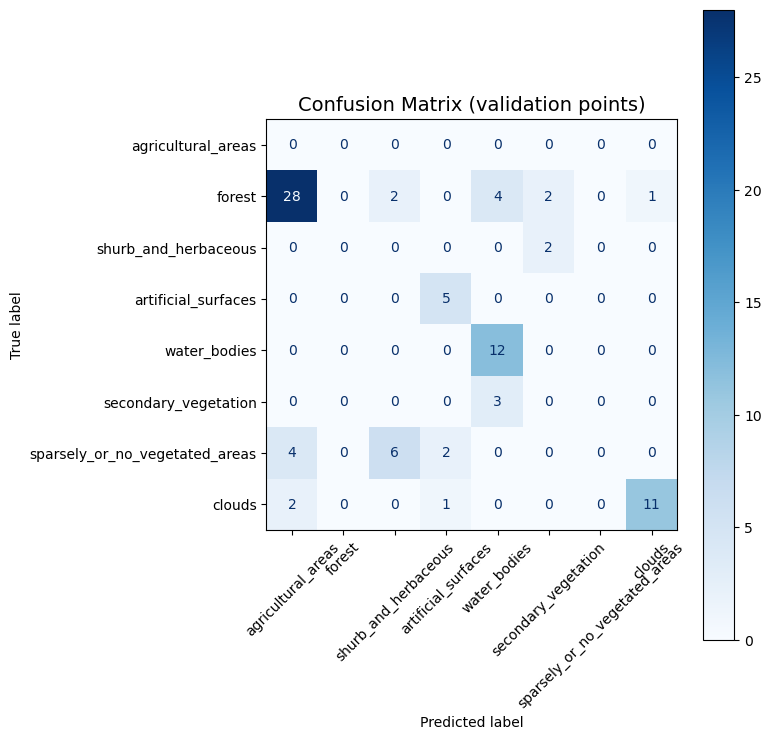

In [70]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report, accuracy_score

# --------------------------------------------
# Compute confusion matrix
# --------------------------------------------
cm = confusion_matrix(y_true_ids, y_pred, labels=list(class_to_code.values()))

# Create a display object for visualization
disp = ConfusionMatrixDisplay(
    confusion_matrix=cm,
    display_labels=[code_to_class[c] for c in sorted(code_to_class)]
)

# Plot the confusion matrix
fig, ax = plt.subplots(figsize=(8, 8))
disp.plot(ax=ax, cmap="Blues", xticks_rotation=45)
ax.set_title("Confusion Matrix (validation points)", fontsize=14)
plt.tight_layout()
plt.show()

In [71]:
# --------------------------------------------
#Classification report and accuracy
# --------------------------------------------
acc = accuracy_score(y_true_ids, y_pred)
print(f"Overall accuracy: {acc:.4f}\n")

# classification_report imprimirá Precision, Recall, F1-score por clase
report = classification_report(
    y_true_ids,
    y_pred,
    labels=list(class_to_code.values()),
    target_names=[code_to_class[c] for c in sorted(code_to_class)],
    zero_division=0
)
print("Classification Report:\n")
print(report)

Overall accuracy: 0.3011

Classification Report:

                                precision    recall  f1-score   support

            agricultural_areas       0.00      0.00      0.00         0
                        forest       0.00      0.00      0.00        40
          shurb_and_herbaceous       0.00      0.00      0.00         3
           artificial_surfaces       0.62      1.00      0.77         5
                  water_bodies       0.63      1.00      0.77        12
          secondary_vegetation       0.00      0.00      0.00         3
sparsely_or_no_vegetated_areas       0.00      0.00      0.00        16
                        clouds       0.92      0.79      0.85        14

                     micro avg       0.33      0.30      0.31        93
                     macro avg       0.27      0.35      0.30        93
                  weighted avg       0.25      0.30      0.27        93



- **Lo que mejor clasifica**:  
  - _artificial_surfaces_ y _water_bodies_ (ambas con recall=1.00).  
  - _clouds_ sale casi perfecta (precision alta).  

- **Lo que peor**:  
  - _forest_ nunca la atina (recall=0).  
  - _shrub_and_herbaceous_, _secondary_vegetation_ y _sparsely_or_no_vegetated_areas_ tampoco.

El modelo **no es una maravilla :(**: solo acierta cerca del 30 % de los puntos, y varias clases se confunden por completo (especialmente “bosque” y “arbustales/herbáceas”).  
Sin embargo, **lo mejor** que hace es identificar bien las _superficies artificiales_ y los _cuerpos de agua_, seguido de las _nubes_. Todo lo demás termina siendo una caca de confusión.

- **What it classifies best**:
  - _artificial_surfaces_ and _water_bodies_ (both with recall=1.00).
  - _clouds_ are almost perfectly classified (high precision).

- **What it classifies worst**:
  - _forest_ is never correctly identified (recall=0).
  - _shrub_and_herbaceous_, _secondary_vegetation_, and _sparsely_or_no_vegetated_areas_ are also poorly classified.

The model **isn't great :(**; it only correctly classifies around 30% of the points, and several classes are completely confused (particularly "forest" and "shrub/herbaceous areas").  
However, **the best aspect** is that it identifies _artificial surfaces_ and _water bodies_ correctly, followed by _clouds_. Everything else ends up being a confusing mess.